In [1]:
%run Solution.ipynb
%run ArrheniusDiagram.ipynb

<Figure size 640x480 with 1 Axes>

In [2]:
def calculate_delta_r1(T):
    return 2 * G0('Al', T) + 2 * G0('HCl', T) - 2 * G0('AlCl', T) - G0('H2', T)

def calculate_delta_r2(T):
    return G0('Al', T) + 2 * G0('HCl', T) - G0('AlCl2', T) - G0('H2', T)

def calculate_delta_r3(T):
    return 2 * G0('Al', T) + 6 * G0('HCl', T) - 2 * G0('AlCl3', T) - 3 * G0('H2', T)

In [3]:
Pa = 100000

def K1(T, R = 8.314):
    return math.exp(-1 * calculate_delta_r1(T) / (R * T)) / Pa

def K2(T, R = 8.314):
    return math.exp(-1 * calculate_delta_r2(T) / (R * T))

def K3(T, R = 8.314):
    return math.exp(-1 * calculate_delta_r3(T) / (R * T)) / Pa



K1, K2, K3 - температурно-зависимые константы равновесия реакций, полученные для реакций R1-R3 при помощи применения правила Гиббса для данных реакций и законов действующих масс.

In [4]:
T = 623.15
print(K1(T))
print(K2(T))
print(K3(T))

7.497131271125371e-07
7.221267004644182e-08
4.062199476332757e-49


In [5]:
print(D('AlCl', T))
print(D('AlCl2', T))
print(D('AlCl3', T))
print(D('HCl', T))
print(D('H2', T))

0.000191129931554728
0.00014747988098603198
0.00015245155020045148
0.0002736394738546893
0.0008762807050502889


In [6]:
PG = {
   'AlCl':0,
   'AlCl2':0,
   'AlCl3':0,
   'H2':0,
   'HCl':10000,
   'N2':90000
}

# (D('AlCl', T) * (PG['AlCl'] - AlCl) + 2 * D('AlCl2', T) * (PG['AlCl2'] - AlCl2) + \
#         3 * D('AlCl3', T) * (PG['AlCl3'] - AlCl3))

T = 623.15
HCl, AlCl, H2, AlCl2, AlCl3 = sy.symbols('HCl AlCl H2 AlCl2 AlCl3')
X = sy.Matrix([
    K1(T) * AlCl**2 - K2(T) * AlCl2,
    ((D('AlCl', T) * (PG['AlCl'] - AlCl) + 2 * D('AlCl2', T) * (PG['AlCl2'] - AlCl2) + \
        3 * D('AlCl3', T) * (PG['AlCl3'] - AlCl3))/D('HCl', T) + PG['HCl'])**2 - K2(T) * AlCl2 * \
    ((D('AlCl', T) * (PG['AlCl'] - AlCl) + 2 * D('AlCl2', T) * (PG['AlCl2'] - AlCl2) + \
        3 * D('AlCl3', T) * (PG['AlCl3'] - AlCl3))/(2*D('H2', T)) + PG['H2']),
    (K2(T) * AlCl2)**3 - K3(T) * AlCl3**2
])
Y = [AlCl, AlCl2, AlCl3]
X.jacobian(Y)

Matrix([
[                                                                   1.49942625422507e-6*AlCl,                                                                      -7.22126700464418e-8,                                                                                          0],
[0.975730567746483*AlCl + 1.50578852394018*AlCl2 + 2.33482484539568*AlCl3 - 13969.4707684041, 1.50578852394018*AlCl + 2.3237962955969*AlCl2 + 3.60320007779103*AlCl3 - 21558.2757719156, 2.33482484539568*AlCl + 3.60320007779103*AlCl2 + 5.58700038604647*AlCl3 - 33427.5347162978],
[                                                                                          0,                                                             1.12969567064259e-21*AlCl2**2,                                                                -8.12439895266551e-49*AlCl3]])

In [7]:
ans = newton_method(X * (10 ** 40), Y, [1, 1, 1])
P = {'AlCl': ans[0], 'AlCl2': ans[1], 'AlCl3': ans[2]}
print(P)

{'AlCl': 0.0642136015618190, 'AlCl2': 0.333333333334125, 'AlCl3': 5982.84972479595}


In [8]:
def get_res(T, ro=2697):
    X = sy.Matrix([
    K1(T) * AlCl**2 - K2(T) * AlCl2,
    ((D('AlCl', T) * (PG['AlCl'] - AlCl) + 2 * D('AlCl2', T) * (PG['AlCl2'] - AlCl2) + \
        3 * D('AlCl3', T) * (PG['AlCl3'] - AlCl3))/D('HCl', T) + PG['HCl'])**2 - K2(T) * AlCl2 * \
    ((D('AlCl', T) * (PG['AlCl'] - AlCl) + 2 * D('AlCl2', T) * (PG['AlCl2'] - AlCl2) + \
        3 * D('AlCl3', T) * (PG['AlCl3'] - AlCl3))/(2*D('H2', T)) + PG['H2']),
    (K2(T) * AlCl2)**3 - K3(T) * AlCl3**2
    ])
    Y = [AlCl, AlCl2, AlCl3]
    ans = newton_method(X * (10 ** 60), Y, [1, 1, 1], ITER=1000)
    P = {'AlCl': ans[0], 'AlCl2': ans[1], 'AlCl3': ans[2]}
    G_AlCl = G('AlCl', T, PG, P)
    G_AlCl2 = G('AlCl2', T, PG, P)
    G_AlCl3 = G('AlCl3', T, PG, P)
    V = (G_AlCl + G_AlCl2 + G_AlCl3) * bank_td['Al']['mu'] * 1e9 / ro
    return [G_AlCl, G_AlCl2, G_AlCl3, V]

Для более произодительного и быстрого решения данной системы нелинейных уравнений мы упростили изначально заданную систему с 5 переменными до системы с 3мя переменными, выразив $P_{HCl}^{e}$ и $P_{H_2}^{e}$ через $P_{AlCl}^{e}$, $P_{AlCl_2}^{e}$ и $P_{AlCl_3}^{e}$. В результате получилась такая система:


$
\left\{\begin{matrix}
 & K_1 * (P_{AlCl}^{e})^{2} - K_2 * P_{AlCl_2} = 0 & \\ 
 & \Theta / D_{HCl} + K_2 * P_{AlCl_2}^e * \Theta / (2 * D_{H2}) + (P_{HCl}^g)^2 + P_{H2}^g = 0  & \\ 
 & (K_2 * P_{AlCl_2}^e)^3 - K_3 * (P_{AlCl_3}^e)^2 = 0 & 
\end{matrix}\right.$


где $\Theta = D_{AlCl} * (P_{AlCl}^g - P_{AlCl}^{e}) + 2 * D_{AlCl_2} * (P_{AlCl_2}^g - P_{AlCl_2}^{e}) + 3 * D_{AlCl_3} * (P_{AlCl_3}^g - P_{AlCl_3}^{e})$

In [9]:
ts = 350
tf = 650
T = np.linspace(ts + 273.15, tf + 273.15)
G1_res = []
G2_res = []
G3_res = []
V_res = []
for t in T:
    curr_res = get_res(t)
    G1_res.append(curr_res[0])
    G2_res.append(curr_res[1])
    G3_res.append(curr_res[2])
    V_res.append(curr_res[3])


График зависимости G_AlCl от температуры


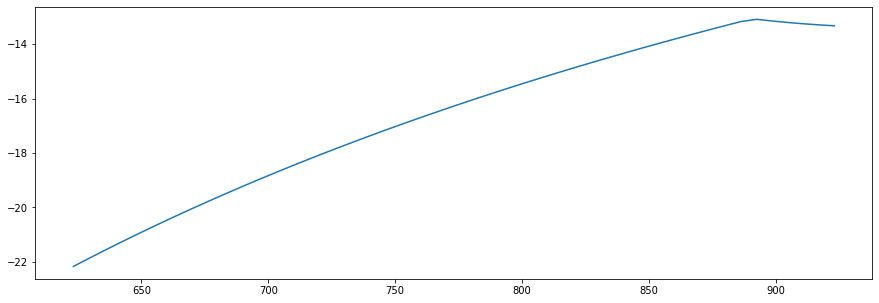

График зависимости G_AlCl2 от температуры


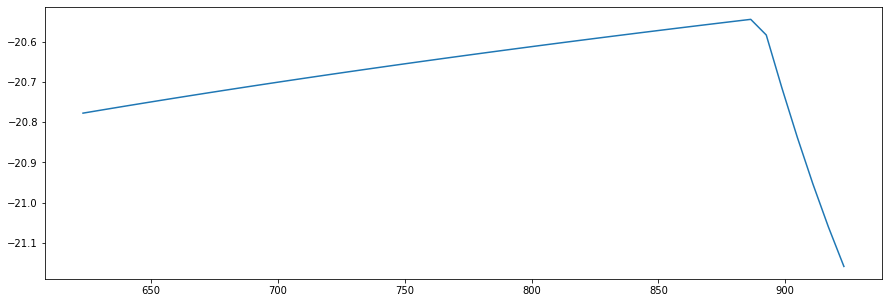

График зависимости G_AlCl3 от температуры


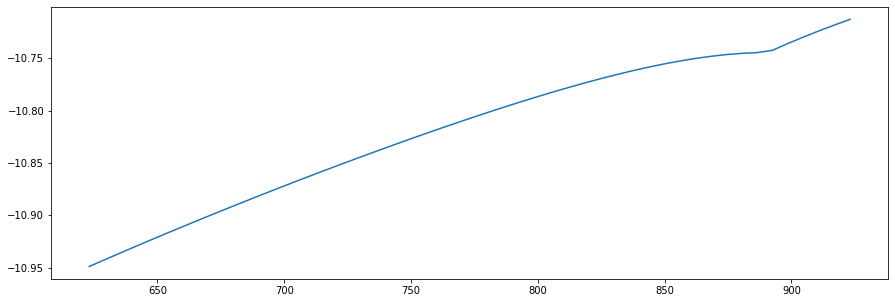

График зависимости V от температуры


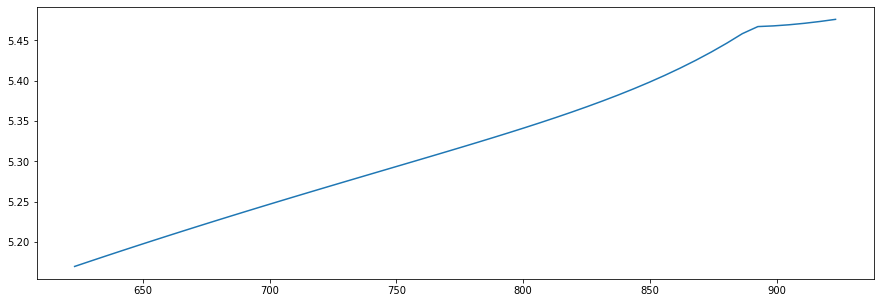

In [10]:
print("График зависимости G_AlCl от температуры")
print_graph_arr(T, G1_res)
print("График зависимости G_AlCl2 от температуры")
print_graph_arr(T, G2_res)
print("График зависимости G_AlCl3 от температуры")
print_graph_arr(T, G3_res)
print("График зависимости V от температуры")
print_graph_arr(T, V_res)